# ECE-GY 9163: Machine Learning for Cyber Security
## Lab 3
### Vahan Babushkin

## Designing a backdoor detector for BadNets trained on the YouTube Face dataset using the pruning defense. 

In [1]:
# all necessary imports
import os
import tarfile
import requests
import re
import sys
import warnings
warnings.filterwarnings('ignore')
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.font_manager as font_manager
import cv2

Select online or offline version:

In [2]:
colab = False

Define function to load the data

In [3]:
# load data
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

We also need an utility to get index of the layer by name (borrowed from https://stackoverflow.com/questions/50151157/keras-how-to-get-layer-index-when-already-know-layer-name)

In [4]:
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx

The cell below downloads the data to drive if colab is used:

In [5]:
if colab:
    from google.colab import drive
    drive.mount('/content/gdrive')

We will be using the clean validation data (valid.h5) from cl folder to design the defense and clean test data (test.h5 from cl folder) and  sunglasses poisoned test data (bd_test.h5 from bd folder) to evaluate the models.

In [6]:
if colab:
    data_path ="/content/gdrive/MyDrive/Colab Notebooks"
else:
    data_path = "/Users/vahan/Desktop/NYUAD PhD PROGRAM/COURSES/EL-GY-9163 MACHINE LEARNING FOR CYBER-SECURITY/HW/HW3"

We define the corresponding arrays to store the clean/badnet validation/test data:

In [7]:
poisoned_data_valid_filename = data_path+"/data/Lab3/bd/bd_valid.h5"
clean_data_valid_filename = data_path+"/data/Lab3/cl/valid.h5"

poisoned_data_test_filename = data_path+"/data/Lab3/bd/bd_test.h5"
clean_data_test_filename = data_path+"/data/Lab3/cl/test.h5"

Read the data:

In [8]:
cl_x_valid, cl_y_valid = data_loader(clean_data_valid_filename)
bd_x_valid, bd_y_valid = data_loader(poisoned_data_valid_filename)

cl_x_test, cl_y_test = data_loader(clean_data_test_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_test_filename)

Visualizing the clean validation data

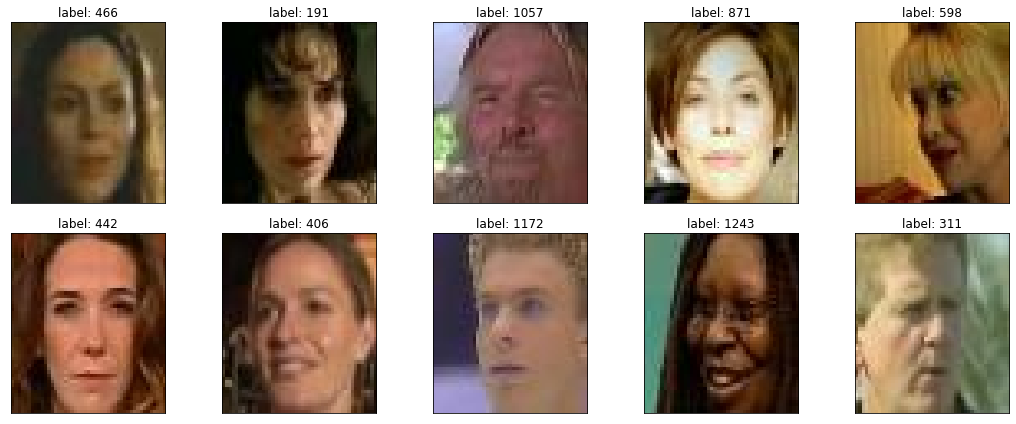

In [9]:
#plot some images from the validation set (see https://mrdatascience.com/how-to-plot-mnist-digits-using-matplotlib/)
num = 10
np.random.seed(45)
randIdx = [np.random.randint(10000) for i in range(num)]
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(cl_x_valid[randIdx[i]].astype('uint8'))
    ax.set_title('label: {:.0f}'.format(cl_y_valid[randIdx[i]]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

Visualizing the sunglasses poisioned validation data

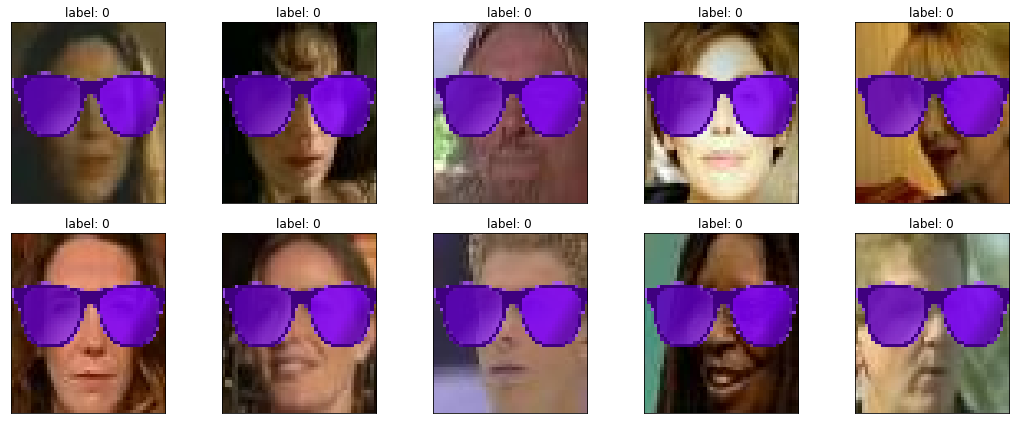

In [10]:
#plot some images from the validation set (see https://mrdatascience.com/how-to-plot-mnist-digits-using-matplotlib/)
num = 10
np.random.seed(45)
randIdx = [np.random.randint(10000) for i in range(num)]
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(bd_x_valid[randIdx[i]].astype('uint8'))
    ax.set_title('label: {:.0f}'.format(bd_y_valid[randIdx[i]]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

Loading backdoor model and its weights

In [11]:
# load model
model = keras.models.load_model(data_path+"/models/bd_net.h5")
model.load_weights(data_path+"/models/bd_weights.h5")

Outputting the summary of the model

In [12]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[0][0]                     
____________________________________________________________________________________________

In [14]:
# visualize the network
if colab:
    from keras.utils.vis_utils import plot_model
    plot_model(model, to_file=data_path+"/MODEL_VISUALIZATION/bd_net.png", show_shapes=True, show_layer_names=True)

Get index of the last pooling layer.
We need to get activations from the last poolinglastConvLayerIdx = getLayerIndexByName(model, "conv_3") # before the fc_1 and pool_3 there is conv_3 layer (pool_3), which is the next after conv_3, so it's index is:

In [15]:
lastPoolLayerIdx = getLayerIndexByName(model, "pool_3")

We will be modifying channels in the convolutional layer conv_3 which is before the last max pooling layer pool_3: 

In [16]:
lastConvLayerIdx = getLayerIndexByName(model, "conv_3") # before the fc_1 and pool_3 there is conv_3

Redefine model to output right after the last pooling layer ("pool_3")

In [17]:
# https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
tmpModel = Model(inputs=model.inputs, outputs=model.layers[lastPoolLayerIdx].output)
tmpModel.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 55, 47, 3)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 52, 44, 20)        980       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 26, 22, 20)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 20, 40)        7240      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 12, 10, 40)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 10, 8, 60)         21660     
_________________________________________________________________
pool_3 (MaxPooling2D)        (None, 5, 4, 60)         

Get feature map for last pooling layer ("pool_3") using the clean validation data

In [18]:
feature_maps_cl = tmpModel(cl_x_valid)
averageActivationsCl = np.mean(feature_maps_cl,0)

Show the activated neurons (channels) for clean validation data.

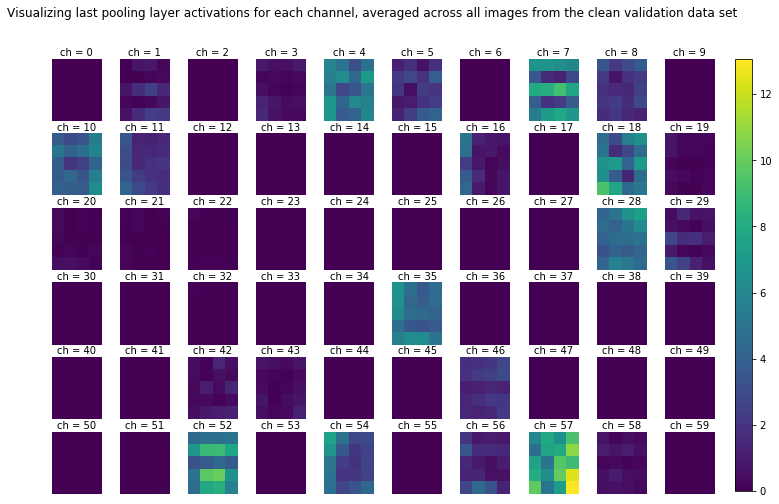

In [19]:
col = 10# to arrange them in 10 columns and 6 rows
fig, axs = plt.subplots(6, 10, figsize=(12, 8), sharex=False, sharey=False)
for i in range(averageActivationsCl.shape[2]):
    axs[i // col, i % col].set_title('ch = '+str(i),fontsize=10, y=0.95)
    im = axs[i // col, i % col ].imshow(averageActivationsCl[:,:,i],vmin=np.min(averageActivationsCl), vmax=np.max(averageActivationsCl))
    axs[i // col, i % col ].invert_yaxis()
    axs[i // col, i % col ].set_axis_off()
    fig.subplots_adjust(right=0.9)
ax_x_start  = 0.92
ax_x_width  = 0.02
ax_y_start  = 0.13
ax_y_height = 0.75
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im,cax=cbar_ax)
clb.mappable.set_clim(np.min(averageActivationsCl), np.max(averageActivationsCl))
clb.ax.set_title('', fontsize=14)  # title on top of colorbar
plt.suptitle("Visualizing last pooling layer activations for each channel, averaged across all images from the clean validation data set", fontsize=12, y=0.97);


Get feature map for last pooling layer ("pool_3") using the backdoored validation data

In [20]:
feature_maps_bd = tmpModel(bd_x_valid)
averageActivationsBd = np.mean(feature_maps_bd,0)

Show the activated neurons (channels) for backdoored validation data.

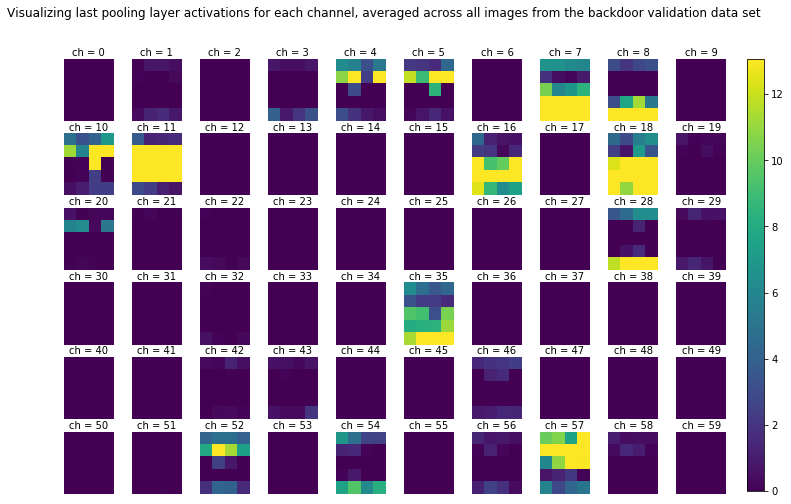

In [21]:
col = 10# to arrange them in 10 columns and 6 rows
fig, axs = plt.subplots(6, 10, figsize=(12, 8), sharex=False, sharey=False)
for i in range(averageActivationsBd.shape[2]):
    axs[i // col, i % col].set_title('ch = '+str(i),fontsize=10, y=0.95)
    im = axs[i // col, i % col ].imshow(np.abs(averageActivationsBd[:,:,i]),vmin=np.min(averageActivationsCl), vmax=np.max(averageActivationsCl))
    axs[i // col, i % col ].invert_yaxis()
    axs[i // col, i % col ].set_axis_off()
    fig.subplots_adjust(right=0.9)
ax_x_start  = 0.92
ax_x_width  = 0.02
ax_y_start  = 0.13
ax_y_height = 0.75
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im,cax=cbar_ax)
clb.mappable.set_clim(np.min(averageActivationsCl), np.max(averageActivationsCl))
clb.ax.set_title('', fontsize=14)  # title on top of colorbar
plt.suptitle("Visualizing last pooling layer activations for each channel, averaged across all images from the backdoor validation data set", fontsize=12, y=0.97);


We can see while there are more neurons in corresponding layers are deactivated for the backdoored validation data, some neurons are getting extremely over-activated (the colormaps on both images are represented in the range of activations for clean data(upper image)). Therefore, an appropriate pruning technics should also take this fact into consideration, i.e. it is clearly a sign of pruning-aware attack -- the attacker recorded the bad behaviour into mostly activated neurons and not into deactivated ones. In this homework we will be gradually pruning the neurons depending on the average activation of the channel.

We will be using only clean validation data (valid.h5) to design the pruning defense. First we average all backdoored activations within a single channel (neuron) and sort them in increasing order

In [22]:
avgActivationsByChannels = np.mean(np.abs(feature_maps_cl),axis=(0, 1, 2))
idxToPrune = np.argsort(np.abs(avgActivationsByChannels)) # increasing  order

Get the conv_4 layer weights and biases from the original network that will be using for prunning

In [23]:
lastConvLayerWeights = model.layers[lastConvLayerIdx].get_weights()[0]
lastConvLayerBiases  = model.layers[lastConvLayerIdx].get_weights()[1]

Output of the original badnet accuracy on the validation data:

In [24]:
# First create clones of the original badnet model (reload it from the drive to avoid any modifications to the original model)
# The result of repairing B will be B_prime

B = keras.models.load_model(data_path+"/models/bd_net.h5")
B.load_weights(data_path+"/models/bd_weights.h5")

B_prime = keras.models.load_model(data_path+"/models/bd_net.h5")
B_prime.load_weights(data_path+"/models/bd_weights.h5")

# get the original badnet model accuracy on the validation data
cl_label_p = np.argmax(B(cl_x_valid), axis=1)
clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_valid)) * 100

# get the original badnet model success rate on the validation data
bd_label_p = np.argmax(B(bd_x_valid), axis=1)
asr = np.mean(np.equal(bd_label_p, bd_y_valid)) * 100

print("Clean validation accuracy before modification {0:3.6f}, attack success rate = {1:3.6f}".format(clean_accuracy, asr))
K.clear_session()

Clean validation accuracy before modification 98.649000, attack success rate = 100.000000


Now iterate over all indices to prune and save models when the validation accuracy drops below 2%, 4% and 10% actual accuracy.

In [25]:
totalPercentChannelsRemoved = np.zeros((60))
totalCleanAccuracyValid = np.zeros((60))
totalAttackSuccessRateValid = np.zeros((60))
totalCleanAccuracyTest = np.zeros((60))
totalAttackSuccessRateTest = np.zeros((60))
percentValidationAccuracy = []
isModelSaved = [0,0,0] # Array of flags to check if the model has been saved. 
# The first flag is for saving the model which validation acccuracy drops below 2%, 
# the second is for 4% and the third is for 10%
zeroWeightsArray = np.zeros(lastConvLayerWeights.shape[0:3])
iter = 0
for chIdx in idxToPrune:
    # remove one channel at a time
    lastConvLayerWeights[:,:,:,chIdx] = zeroWeightsArray
    lastConvLayerBiases[chIdx] = 0
    
    # update weights and biases of the badnet 
    B_prime.layers[lastConvLayerIdx].set_weights([lastConvLayerWeights,lastConvLayerBiases])
    
    # evaluate the updated model predictions on the clean validation data
    cl_label_p_valid = np.argmax(B_prime(cl_x_valid), axis=1)
    clean_accuracy_valid = np.mean(np.equal(cl_label_p_valid, cl_y_valid)) * 100

    if (clean_accuracy - clean_accuracy_valid)/clean_accuracy *100 >=2 and not isModelSaved[0]:
        B_prime.save(data_path+'/REPAIRED_MODELS/bd_repaired_2.h5')
        B_prime.save_weights(data_path+'/REPAIRED_MODELS/bd_repaired_2_weights.h5')
        print("Validation accuracy drops 2% below the original accuracy. Model has been saved as bd_repaired_2.h5")
        percentValidationAccuracy.append(clean_accuracy_valid)
        isModelSaved[0] = 1
    if (clean_accuracy - clean_accuracy_valid)/clean_accuracy *100 >=4  and not isModelSaved[1]:
        B_prime.save(data_path+'/REPAIRED_MODELS/bd_repaired_4.h5')
        B_prime.save_weights(data_path+'/REPAIRED_MODELS/bd_repaired_4_weights.h5')
        print("Validation accuracy drops 4% below the original accuracy. Model has been saved as bd_repaired_4.h5")
        percentValidationAccuracy.append(clean_accuracy_valid)
        isModelSaved[1] = 1
    if (clean_accuracy - clean_accuracy_valid)/clean_accuracy *100>=10 and not isModelSaved[2]:
        B_prime.save(data_path+'/REPAIRED_MODELS/bd_repaired_10.h5')
        B_prime.save_weights(data_path+'/REPAIRED_MODELS/bd_repaired_10_weights.h5')
        print("Validation accuracy drops 10% below the original accuracy. Model has been saved as bd_repaired_10.h5")
        percentValidationAccuracy.append(clean_accuracy_valid)
        isModelSaved[2] = 1

    # evaluate the updated model attack success rate on the validation data
    bd_label_p_valid = np.argmax(B_prime(bd_x_valid), axis=1)
    asr_valid = np.mean(np.equal(bd_label_p_valid, bd_y_valid)) * 100

    # evaluate the updated model accuracy on the clean test data
    cl_label_p_test = np.argmax(B_prime(cl_x_test), axis=1)
    clean_accuracy_test = np.mean(np.equal(cl_label_p_test, cl_y_test)) * 100

    # evaluate the updated model model attack success rate on the test data
    bd_label_p_test = np.argmax(B_prime(bd_x_test), axis=1)
    asr_test= np.mean(np.equal(bd_label_p_test, bd_y_test)) * 100

    percentChannelsRemoved=(iter + 1) / lastConvLayerWeights.shape[3]
    print("Iteration = {0:3d}, channel removed = {1:3d}, percent channels removed = {2:3.6f}\nClean validation accuracy after modification: {3:3.6f}, attack success rate =  {4:3.6f}".format(iter,chIdx,percentChannelsRemoved*100,clean_accuracy_valid, asr_valid))
    
    K.clear_session()
    
    totalPercentChannelsRemoved[iter] = percentChannelsRemoved
    totalCleanAccuracyValid[iter] = clean_accuracy_valid
    totalAttackSuccessRateValid[iter] = asr_valid
    totalCleanAccuracyTest[iter] = clean_accuracy_test
    totalAttackSuccessRateTest[iter] = asr_test
    iter+=1

Iteration =   0, channel removed =   0, percent channels removed = 1.666667
Clean validation accuracy after modification: 98.649000, attack success rate =  100.000000
Iteration =   1, channel removed =  26, percent channels removed = 3.333333
Clean validation accuracy after modification: 98.649000, attack success rate =  100.000000
Iteration =   2, channel removed =  27, percent channels removed = 5.000000
Clean validation accuracy after modification: 98.649000, attack success rate =  100.000000
Iteration =   3, channel removed =  30, percent channels removed = 6.666667
Clean validation accuracy after modification: 98.649000, attack success rate =  100.000000
Iteration =   4, channel removed =  31, percent channels removed = 8.333333
Clean validation accuracy after modification: 98.649000, attack success rate =  100.000000
Iteration =   5, channel removed =  33, percent channels removed = 10.000000
Clean validation accuracy after modification: 98.649000, attack success rate =  100.0000

Iteration =  48, channel removed =   5, percent channels removed = 81.666667
Clean validation accuracy after modification: 91.495627, attack success rate =  99.991340
Iteration =  49, channel removed =   8, percent channels removed = 83.333333
Clean validation accuracy after modification: 91.019312, attack success rate =  99.982679
Iteration =  50, channel removed =  11, percent channels removed = 85.000000
Clean validation accuracy after modification: 89.174677, attack success rate =  80.739586
Validation accuracy drops 10% below the original accuracy. Model has been saved as bd_repaired_10.h5
Iteration =  51, channel removed =  54, percent channels removed = 86.666667
Clean validation accuracy after modification: 84.437516, attack success rate =  77.015675
Iteration =  52, channel removed =  10, percent channels removed = 88.333333
Clean validation accuracy after modification: 76.487399, attack success rate =  35.714904
Iteration =  53, channel removed =  28, percent channels removed

Ploting the accuracy on clean validation data and the attack success rate (on backdoored validation data) as a function of the fraction of channels pruned. 

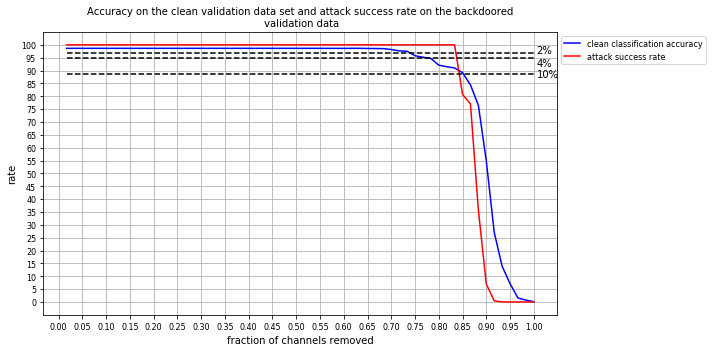

In [26]:
fig, axs = plt.subplots(figsize=(10, 5))
axs.tick_params(axis='x', labelsize=8)
axs.tick_params(axis='y', labelsize=8)
axs.set_yticks(np.arange(0, 101, 5))
axs.set_xticks(np.arange(0, 1.001, 0.05))
axs.set_ylabel('rate', fontsize=10)
axs.set_xlabel('fraction of channels removed', fontsize=10)
axs.set_title("Accuracy on the clean validation data set and attack success rate on the backdoored\n validation data",fontsize=10)
axs.plot(totalPercentChannelsRemoved, totalCleanAccuracyValid, 'b-', label="clean classification accuracy")
axs.plot(totalPercentChannelsRemoved, totalAttackSuccessRateValid, 'r-', label='attack success rate')
font = font_manager.FontProperties(size=8)
axs.legend(loc='best', bbox_to_anchor=(1, 1), prop=font)
axs.plot([totalPercentChannelsRemoved[0],totalPercentChannelsRemoved[-1]],[clean_accuracy*0.98,clean_accuracy*0.98],'k--')
axs.text(0.96, 0.925, '2%' , fontsize=10, transform=axs.transAxes)
axs.plot([totalPercentChannelsRemoved[0],totalPercentChannelsRemoved[-1]],[clean_accuracy*0.96,clean_accuracy*0.96],'k--')
axs.text(0.96, 0.88, '4%' , fontsize=10, transform=axs.transAxes)
axs.plot([totalPercentChannelsRemoved[0],totalPercentChannelsRemoved[-1]],[clean_accuracy*0.90,clean_accuracy*0.90],'k--')
axs.text(0.96, 0.84, '10%' , fontsize=10, transform=axs.transAxes)
plt.grid()
fig.tight_layout()

Ploting the accuracy on clean test data and the attack success rate (on backdoored test data) as a function of the fraction of channels pruned. 

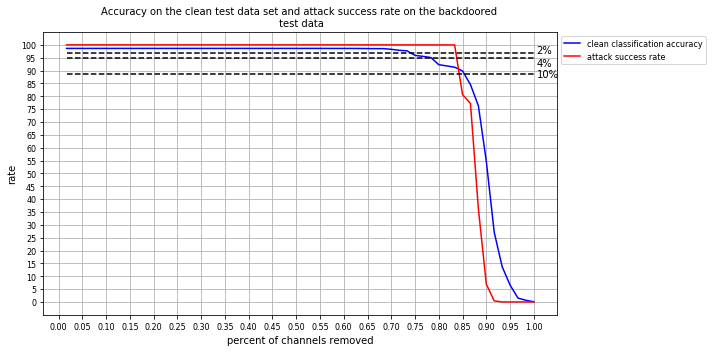

In [27]:
fig, axs = plt.subplots(figsize=(10, 5))
axs.set_yticks(np.arange(0, 101, 5))
axs.set_xticks(np.arange(0, 1.001, 0.05))
axs.tick_params(axis='x', labelsize=8)
axs.tick_params(axis='y', labelsize=8)
axs.set_ylabel('rate', fontsize=10)
axs.set_xlabel('percent of channels removed', fontsize=10)
axs.set_title("Accuracy on the clean test data set and attack success rate on the backdoored \n test data",fontsize=10)
axs.plot(totalPercentChannelsRemoved, totalCleanAccuracyTest, 'b-', label="clean classification accuracy")
axs.plot(totalPercentChannelsRemoved, totalAttackSuccessRateTest, 'r-', label='attack success rate')
font = font_manager.FontProperties(size=8)
axs.legend(loc='best', bbox_to_anchor=(1, 1), prop=font)
axs.plot([totalPercentChannelsRemoved[0],totalPercentChannelsRemoved[-1]],[clean_accuracy*0.98,clean_accuracy*0.98],'k--')
axs.text(0.96, 0.925, '2%' , fontsize=10, transform=axs.transAxes)
axs.plot([totalPercentChannelsRemoved[0],totalPercentChannelsRemoved[-1]],[clean_accuracy*0.96,clean_accuracy*0.96],'k--')
axs.text(0.96, 0.88, '4%' , fontsize=10, transform=axs.transAxes)
axs.plot([totalPercentChannelsRemoved[0],totalPercentChannelsRemoved[-1]],[clean_accuracy*0.90,clean_accuracy*0.90],'k--')
axs.text(0.96, 0.84, '10%' , fontsize=10, transform=axs.transAxes)
plt.grid()
fig.tight_layout()

From these plots we can observe that backdoor attack success rate dops sharply when most of the neurons are pruned. However, at the beginning the attack success rate remains around 100% and the clean classification accuracy remains constant. It can be described as follows -- at the beginning we prune neurons which are all zeros or poorly activated, and thus, are not used either by a hones network or badnet. Then when the number of channels removed is above 70%  and below 83% of their initial quantity, we notice drop in the clean classification accuracy while. It means that we are pruning now neuorns that are responsible for classifying the clear inputs but not neuronts, that are activated by the bad inputs. And finally, starting from 83% of all neurons removed both the attack success rate and the clean classification accuracy drop, meaning that now we are now removing those neurons that are both activated by clean and bad inputs. In this case the backdoor attack is disabled, but the clean classification accuracy also drops (e.g. decrease of the attack success rate to 6% results in decline in clean classification accuracy to almost 50%). 

Now we need to combine the models into a repaired goodnet G  that outputs the correct class if the test input is clean and class N+1 if the input is backdoored. One way to do it is to "subclass" the models in Keras: 

In [28]:
#https://stackoverflow.com/questions/64983112/keras-vertical-ensemble-model-with-condition-in-between
class G(tf.keras.Model):
    def __init__(self, B, B_prime):
        super(G, self).__init__()
        self.B = B
        self.B_prime = B_prime

    def predict(self,data):
        y = np.argmax(self.B(data), axis=1)
        y_prime = np.argmax(self.B_prime(data), axis=1)
        tmpRes = np.array([y[i] if y[i] == y_prime[i] else 1283 for i in range(y.shape[0])])
        res = np.zeros((y.shape[0],1284))
        res[np.arange(tmpRes.size),tmpRes] = 1
        return res

    # For small amount of inputs that fit in one batch, directly using call() is recommended for faster execution, 
    # e.g., model(x), or model(x, training=False) is faster then model.predict(x) and do not result in
    # memory leaks (see for more details https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict)
    def call(self,data):
        y = np.argmax(self.B(data), axis=1)
        y_prime = np.argmax(self.B_prime(data), axis=1)
        tmpRes = np.array([y[i] if y[i] == y_prime[i] else 1283 for i in range(y.shape[0])])
        res = np.zeros((y.shape[0],1284))
        res[np.arange(tmpRes.size),tmpRes] = 1
        return res

However, Keras prevents from saving this kind of subclassed model as HDF5 file since it is not serializable. However, we still can use this architecture for model evaluation.

Load the saved B' models 

In [29]:
B_prime_2  = keras.models.load_model(data_path+"/REPAIRED_MODELS/bd_repaired_2.h5")
B_prime_2.load_weights(data_path+"/REPAIRED_MODELS/bd_repaired_2_weights.h5")

B_prime_4  = keras.models.load_model(data_path+"/REPAIRED_MODELS/bd_repaired_4.h5")
B_prime_4.load_weights(data_path+"/REPAIRED_MODELS/bd_repaired_4_weights.h5")

B_prime_10  = keras.models.load_model(data_path+"/REPAIRED_MODELS/bd_repaired_10.h5")
B_prime_10.load_weights(data_path+"/REPAIRED_MODELS/bd_repaired_10_weights.h5")


Check performance of the repaired models on the test data:

In [30]:
cl_label_p = np.argmax(B_prime_2.predict(cl_x_test), axis=1)
clean_accuracy_B_2 = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for B_prime_2:', clean_accuracy_B_2)

bd_label_p = np.argmax(B_prime_2.predict(bd_x_test), axis=1)
asr_B_2 = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B_prime_2:', asr_B_2)

cl_label_p = np.argmax(B_prime_4(cl_x_test), axis=1)
clean_accuracy_B_4 = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for B_prime_4:', clean_accuracy_B_4)

bd_label_p = np.argmax(B_prime_4(bd_x_test), axis=1)
asr_B_4 = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B_prime_4:', asr_B_4)

cl_label_p = np.argmax(B_prime_10(cl_x_test), axis=1)
clean_accuracy_B_10 = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for B_prime_10:', clean_accuracy_B_10)

bd_label_p = np.argmax(B_prime_10(bd_x_test), axis=1)
asr_B_10= np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B_prime_10:', asr_B_10)

Clean Classification accuracy for B_prime_2: 95.90023382696803
Attack Success Rate for B_prime_2: 100.0
Clean Classification accuracy for B_prime_4: 92.29150428682775
Attack Success Rate for B_prime_4: 99.98441153546376
Clean Classification accuracy for B_prime_10: 84.54403741231489
Attack Success Rate for B_prime_10: 77.20966484801247


Create repaired networks.

In [31]:
# repaired network for 2% drop below the original accuracy 
G_2=G(B, B_prime_2)
# repaired network for 4% drop below the original accuracy 
G_4=G(B, B_prime_4)
# repaired network for 10% drop below the original accuracy 
G_10=G(B, B_prime_10)

Check the performance of the goodnet models on the test data:

In [32]:
cl_label_p = np.argmax(G_2(cl_x_test), axis=1)
clean_accuracy_G_2 = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for G_2:', clean_accuracy_G_2)

bd_label_p = np.argmax(G_2(bd_x_test), axis=1)
asr_G_2 = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for G_2:', asr_G_2)

cl_label_p = np.argmax(G_4(cl_x_test), axis=1)
clean_accuracy_G_4 = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for G_4:', clean_accuracy_G_4)

bd_label_p = np.argmax(G_4(bd_x_test), axis=1)
asr_G_4 = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for G_4:', asr_G_4)

cl_label_p = np.argmax(G_10(cl_x_test), axis=1)
clean_accuracy_G_10 = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for G_10:', clean_accuracy_G_10)

bd_label_p = np.argmax(G_10(bd_x_test), axis=1)
asr_G_10= np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for G_10:', asr_G_10)


Clean Classification accuracy for G_2: 95.74434918160561
Attack Success Rate for G_2: 100.0
Clean Classification accuracy for G_4: 92.1278254091972
Attack Success Rate for G_4: 99.98441153546376
Clean Classification accuracy for G_10: 84.3335931410756
Attack Success Rate for G_10: 77.20966484801247


Plot barplot:

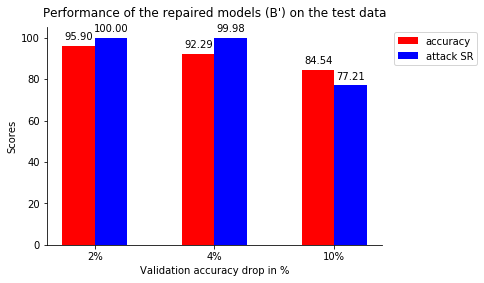

In [39]:
N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.27        # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

yvals = [clean_accuracy_B_2, clean_accuracy_B_4, clean_accuracy_B_10]
rects1 = ax.bar(ind, yvals, width, color='r')
zvals = [asr_B_2, asr_B_4, asr_B_10]
rects2 = ax.bar(ind+width, zvals, width, color='b')

ax.set_ylabel('Scores')
ax.set_xticks(ind+width/2)
ax.set_xticklabels( ('2%', '4%', '10%') )
ax.legend( (rects1[0], rects2[0]), ('accuracy', 'attack SR') ,bbox_to_anchor=(1.3, 1), loc='upper right', ncol=1)
ax.set_title("Performance of the repaired models (B') on the test data", y=1.02)
ax.set_xlabel('Validation accuracy drop in %')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.02*h, '%.2f'%h,
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

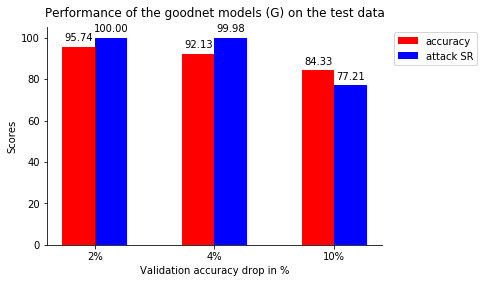

In [40]:
N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.27        # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

yvals = [clean_accuracy_G_2, clean_accuracy_G_4, clean_accuracy_G_10]
rects1 = ax.bar(ind, yvals, width, color='r')
zvals = [asr_G_2, asr_G_4, asr_G_10]
rects2 = ax.bar(ind+width, zvals, width, color='b')

ax.set_ylabel('Scores')
ax.set_xticks(ind+width/2)
ax.set_xticklabels( ('2%', '4%', '10%') )
ax.legend( (rects1[0], rects2[0]), ('accuracy', 'attack SR') ,bbox_to_anchor=(1.3, 1), loc='upper right', ncol=1)
ax.set_title("Performance of the goodnet models (G) on the test data", y=1.02)
ax.set_xlabel('Validation accuracy drop in %')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.02*h, '%.2f'%h,
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

We can notice that the repairing models is not too effective -- in most cases it does not prevent the attack. Only for the repaired network (B') obtained from activations when validation data accuracy drops at least 10% below the original accuracy the success rate is lower compared to the prediction accuracy. The accuracy of Goodnet (G) is slightly lower than of repaired networks (B') since it removes some labels that were misclassifie by badnet. But still the success rate of the attack remains too high, because the repaired badnets (B') still provide 100% success rate. These results suggest that we are dealing with pruning-aware attack, i.e. the attacker recorded the backdoor behavior into the same neurons that are used for classifying the clean data.

Defining own eval method for the BadNet. It takes a test image (in png or jpeg format) as an input, and outputs a class in range [0, 1283].

Since the requirement is a test image (in png or jpeg format), we need to convert some images from .h5 to .png/.jpeg files for evaluation of the performance of the script. 

In [41]:
# convert the .h5 images into .png:
num = 100
np.random.seed(45)
randIdx = [np.random.randint(10000) for i in range(num)]
for i in range(num):
    cv2.imwrite(data_path+"/IMAGES/cl/test_"+str(int(cl_y_test[randIdx[i]]))+"_"+str(i)+".png",cv2.cvtColor(cl_x_test[randIdx[i]].astype('uint8'), cv2.COLOR_RGB2BGR))  # we need to use cv2.cvtColor to convert from RGB to BGR
    cv2.imwrite(data_path + "/IMAGES/cl/valid_" + str(int(cl_y_valid[randIdx[i]])) + "_" + str(i) + ".png",cv2.cvtColor(cl_x_valid[randIdx[i]].astype('uint8'),cv2.COLOR_RGB2BGR))  # we need to use cv2.cvtColor to convert from RGB to BGR
    cv2.imwrite(data_path + "/IMAGES/bd/test_" + str(int(bd_y_test[randIdx[i]])) + "_" + str(i) + ".png",cv2.cvtColor(bd_x_test[randIdx[i]].astype('uint8'),cv2.COLOR_RGB2BGR))  # we need to use cv2.cvtColor to convert from RGB to BGR
    cv2.imwrite(data_path + "/IMAGES/bd/valid_" + str(int(bd_y_valid[randIdx[i]])) + "_" + str(i) + ".png",cv2.cvtColor(bd_x_valid[randIdx[i]].astype('uint8'),cv2.COLOR_RGB2BGR))  # we need to use cv2.cvtColor to convert from RGB to BGR

Test badnetEval with .png files

In [61]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/badnetEval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/cl/test_1_49.png /content/gdrive/MyDrive/Colab\ Notebooks/models/bd_net.h5 /content/gdrive/MyDrive/Colab\ Notebooks/REPAIRED_MODELS/bd_repaired_2.h5
else:
    %run -i  badnetEval.py  IMAGES/bd/test_0_99.png  models/bd_net.h5 REPAIRED_MODELS/bd_repaired_2.h5

Badnet predicted label:               0
Repaired Network predicted label:     0


In [60]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/badnetEval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/cl/test_1_49.png /content/gdrive/MyDrive/Colab\ Notebooks/models/bd_net.h5 /content/gdrive/MyDrive/Colab\ Notebooks/REPAIRED_MODELS/bd_repaired_2.h5
else:
    %run -i  badnetEval.py  IMAGES/cl/test_560_98.jpeg  models/bd_net.h5 REPAIRED_MODELS/bd_repaired_2.h5

Badnet predicted label:             560
Repaired Network predicted label:   560


Test if repaired networks run with original eval.py script and produce similar results:

In [63]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/data/Lab3/cl/valid.h5 /content/gdrive/MyDrive/Colab\ Notebooks/data/Lab3/bd/bd_valid.h5 /content/gdrive/MyDrive/Colab\ Notebooks/models/bd_net.h5
else:
    %run -i 'eval.py' data/Lab3/cl/valid.h5 data/Lab3/bd/bd_valid.h5 models/bd_net.h5

Clean Classification accuracy: 98.64899974019225
Attack Success Rate: 100.0


Check the performance of the repaired models on the test data

For model prunned until the validation accuracy dropped below 2% the original accuracy:

In [69]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/data/Lab3/cl/test.h5 /content/gdrive/MyDrive/Colab\ Notebooks/data/Lab3/bd/bd_test.h5 /content/gdrive/MyDrive/Colab\ Notebooks/REPAIRED_MODELS/bd_repaired_2.h5
else:
    %run -i 'eval.py' data/Lab3/cl/test.h5 data/Lab3/bd/bd_test.h5 REPAIRED_MODELS/bd_repaired_2.h5

Clean Classification accuracy: 95.90023382696803
Attack Success Rate: 100.0


For model prunned until the validation accuracy dropped below 4% the original accuracy:

In [70]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/data/Lab3/cl/test.h5 /content/gdrive/MyDrive/Colab\ Notebooks/data/Lab3/bd/bd_test.h5 /content/gdrive/MyDrive/Colab\ Notebooks/REPAIRED_MODELS/bd_repaired_4.h5
else:
    %run -i 'eval.py' data/Lab3/cl/test.h5 data/Lab3/bd/bd_test.h5 REPAIRED_MODELS/bd_repaired_10.h5

Clean Classification accuracy: 84.54403741231489
Attack Success Rate: 77.20966484801247


For model prunned until the validation accuracy dropped below 10% the original accuracy:

In [72]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/data/Lab3/cl/test.h5 /content/gdrive/MyDrive/Colab\ Notebooks/data/Lab3/bd/bd_test.h5 /content/gdrive/MyDrive/Colab\ Notebooks/REPAIRED_MODELS/bd_repaired_10.h5
else:
    %run -i 'eval.py' data/Lab3/cl/test.h5 data/Lab3/bd/bd_test.h5 REPAIRED_MODELS/bd_repaired_10.h5

Clean Classification accuracy: 84.54403741231489
Attack Success Rate: 77.20966484801247
